# 📡 Имитационное моделирование RFID системы без коллизий

В этом блокноте проводится **имитационное моделирование UHF RFID системы** с одним считывателем и одной меткой без коллизий. Он воспроизводит ключевые графики, ранее представленные в магистерской диссертации, а именно зависимость вероятности чтения пользовательского банка памяти метки от:
1) Скорости движения БПЛА со считывателем для разных M и Tari
2) 

Так как запуск нескольких сетов имитационных RFID моделей (один сет - одна кривая на графике) занимает много времени (десятки минут), в данном блокноте предусмотрена возможность сохранения результатов моделирования в json-файлы. Тогда для построения графиков можно выбрать два варианта: использовать готовые данные из json-файла или перезапустить модели и построить кривые на основе новых данных.


### Импорт необходимых модулей

In [1]:
import numpy as np
import os
import json

from tqdm import tqdm
import matplotlib.pyplot as plt

from pysim.experiments.utility.graphs_style import savefig, GraphConsts, setup_matplotlib
from pysim.models.rfid.cli import prepare_multiple_simulation
from pysim.models.rfid.cli import DEFAULT_TARI, DEFAULT_ENCODING, DEFAULT_TID_WORD_SIZE
from pysim.models.rfid.cli import DEFAULT_READER_OFFSET, DEFAULT_TAG_OFFSET, DEFAULT_ALTITUDE
from pysim.models.rfid.cli import DEFAULT_NUM_TAGS, DEFAULT_POWER, USE_QUERY_ADJUST, DEFAULT_ADJUST_DELTA

In [2]:
json_path = 'result_jsons/rfid/'
IMAGE_DIRECTORY = 'rfid' # Название директории, в которой будут сохраняться изображения

## Зависимость вероятности чтения пользовательского банка памяти метки от скорости движения БПЛА со считывателем для разных M и Tari

Рассматриваются следующие варианты типов кодирования ответов метки (M) и длительности команд считывателя (Tari):
1) M = FM0, Tari = 6,26 мкс
2) M = FM0, Tari = 18,75 мкс
3) M = Miller-2, Tari = 12,5 мкс
4) M = Miller-4, Tari = 6,25 мкс
5) M = Miller-8, Tari = 25 мкс

### Параметры для запуска моделирования

In [3]:
speed_json_path = json_path + 'speed.json'
speed = np.arange(5.0, 72.5, 2.5) # Исследуемые скорости
coding_params = [
    {'encoding': 'FM0', 'tari': 6.25},
    {'encoding': 'FM0', 'tari': 18.75},
    {'encoding': 'M2', 'tari': 12.5},
    {'encoding': 'M4', 'tari': 6.25},
    {'encoding': 'M8', 'tari': 25.0},
]

### Получение результатов

In [4]:
speed_params_list = []
for coding_params_item in coding_params:
    speed_params_list.append({
        'tari': coding_params_item['tari'],
        'encoding': coding_params_item['encoding'],
        'tid_word_size': DEFAULT_TID_WORD_SIZE,
        'reader_offset': DEFAULT_READER_OFFSET,
        'tag_offset': DEFAULT_TAG_OFFSET,
        'altitude': DEFAULT_ALTITUDE,
        'power': DEFAULT_POWER,
        'num_tags': 90,
        'useadjust': USE_QUERY_ADJUST,
        'delta': DEFAULT_ADJUST_DELTA,
    })

In [5]:
def get_speed_probs(speed_params_list, use_json=True, save_results=False):
    if use_json and os.path.exists(speed_json_path):
        with open(speed_json_path, 'r') as f:
            speed_results = json.load(f)
    else:
        speed_results = {}
        for params in tqdm(speed_params_list, desc='Моделирование по скоростям'):
            results = prepare_multiple_simulation('speed', speed=speed, **params)
            inventory_probs = [res[0]['read_tid_prob'] for res in results]
            key = f"M{params['encoding']}_Tari{params['tari']}"
            speed_results[key] = inventory_probs

            if save_results:
                os.makedirs(os.path.dirname(speed_json_path), exist_ok=True)
                with open(speed_json_path, 'w') as f:
                    json.dump(speed_results, f, indent=2)
    return speed_results

speed_results = get_speed_probs(speed_params_list, use_json=False, save_results=True)

Моделирование по скоростям: 100%|██████████| 5/5 [02:00<00:00, 24.11s/it]


### Построение графика

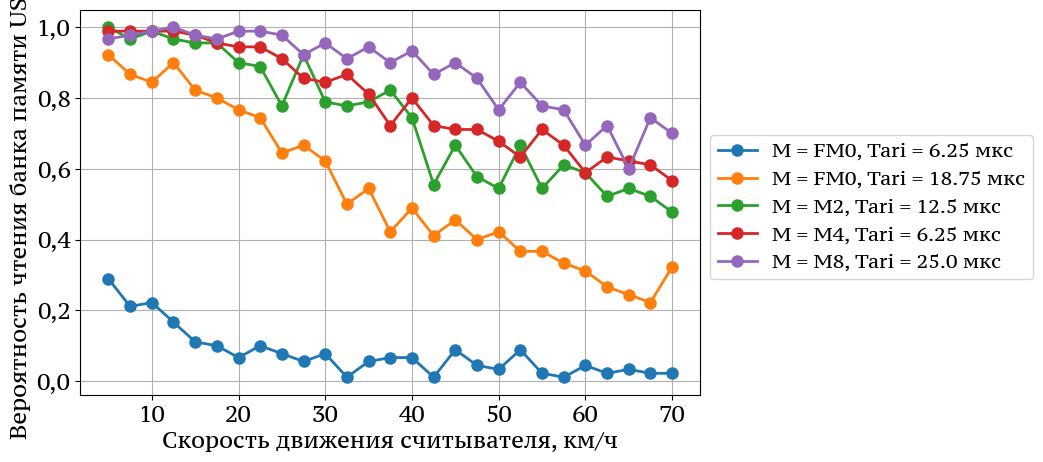

In [6]:
setup_matplotlib()

def plot_speed_probs(
    image_name: str = 'Speed probs', save_fig: bool = False
) -> None:

    fig, ax = plt.subplots(figsize=GraphConsts.FIGSIZE)
    for coding_params_item in coding_params:
        label = f"M = {coding_params_item['encoding']}, Tari = {coding_params_item['tari']} мкс"
        key = f"M{coding_params_item['encoding']}_Tari{coding_params_item['tari']}"
        inventory_probs = speed_results[key]
        ax.plot(speed, inventory_probs, label=label, marker='o')
    ax.set_xlabel('Скорость движения считывателя, км/ч')
    ax.set_ylabel('Вероятность чтения/банка памяти USER')
    ax.grid()
    ax.legend(bbox_to_anchor=(1, 0.7))
    
    if save_fig:
        savefig(name=image_name, directory=IMAGE_DIRECTORY)

# Вызов функции
plot_speed_probs(save_fig=True)